Download the NB: https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/random_walk_deep_net.ipynb

(c) 2017 by [Thomas Wiecki](https://twitter/twiecki) -- [Quantopian Inc.](https://quantopian.com)

Most problems solved by Deep Learning are stationary. A cat is always a cat. The rules of Go have remained stable for 2,500 years, and will likely stay that way. However, what if the world around you *is* changing? This is common, for example when applying Machine Learning in Quantitative Finance. Markets are constantly evolving so features that are predictive in some time-period might not lose their edge while other patterns emerge. Usually, quants would just retrain their classifiers every once in a while. This approach of just re-estimating the same model on more recent data is very common. I find that to be a pretty unsatisfying way modeling, as there are certain shortfalls: 

* The estimation window should be long so as to incorporate as much training data as possible.
* The estimation window should be short so as to incorporate only the most recent data, as old data might be obsolete.
* When you have no estimate of how fast the world around you is changing, there is no principled way of setting the window length to balance these two objectives.

Certainly there is something to be learned even from past data, we just need to instill our models with a sense of time and recency.

Enter random-walk processes. Ever since I learned about them in the [stochastic volatility model](https://blog.quantopian.com/probabilistic-programming-quant-finance/) they have become one of my favorite modeling tricks. Basically, it allows you to turn every static model into a time-sensitive one.

You can read more about the details of a random-walk priors [here](http://pymc-devs.github.io/pymc3/notebooks/stochastic_volatility.html), but the central idea is that, in any time-series model, rather than assuming a parameter to be constant over time, we allow it change gradually, following a random walk. For example, take a logistic regression:

$$
Y_i = f(\beta X_i)
$$

Where $f$ is the logistic function and $\beta$ is our learnable parameter. If we assume that our data is not iid and that $\beta$ is changing over time. We thus need a different $\beta$ for every $i$:

$$
Y_i = f(\beta_i X_i)
$$

Of course, this will just overfit, so we need to constraint our $\beta_i$ somehow. We will assume that while $\beta_i$ is changing over time, it will do so rather gradually by placing a random-walk prior on it:

$$
\beta_t \sim \mathcal{N}(\beta_{t-1}, s^2)
$$

So $\beta_t$ is allowed to only deviate a little bit (determined by the step-width $s$) form its previous value $\beta_{t-1}$. $s$ can be thought of as a stability parameter -- how fast is the world around you changing. 

Let's first generate some toy data and then implement this model in `PyMC3`. We will then use this same trick in a [Neural Network](twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) with hidden layers.

If you would like a more complete introduction to Bayesian Deep Learning, see [my recent ODSC London talk](https://www.youtube.com/watch?v=S9d5nupP_7Q). This blog post takes things one step further so definitely read further below.

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale


import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_context('notebook')

<h3>Generating data</h3>

First, lets generate some toy data -- a simple binary classification problem that's linearly separable. To introduce the non-stationarity, we will rotate this data along the center across time. Safely skip over the next few code cells.

In [2]:
X, Y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1)
X = scale(X)
colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0]+1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)

In [4]:
import base64
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""


def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        anim.save("test.mp4", fps=20, extra_args=['-vcodec', 'libx264'])

        video = open("test.mp4","rb").read()

    anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ims = [] #l, = plt.plot([], [], 'r-')
for i in np.arange(0, len(X), 10):
    ims.append([(ax.scatter(X[:i, 0], X[:i, 1], color=colors[:i]))])

ax.set(xlabel='X1', ylabel='X2')
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.ArtistAnimation(fig, ims,
                                 interval=500, 
                                 blit=True);

display_animation(anim)

The last frame of the video, where all data is plotted is what a classifier would see that has no sense of time. Thus, the problem we set up is impossible to solve when ignoring time, but trivial once you do.

How would we classically solve this? You could just train a different classifier on each subset. But as I wrote above, you need to get the frequency right and you use less data overall.

## Random-Walk Logistic Regression in PyMC3

In [5]:
from pymc3 import HalfNormal, GaussianRandomWalk, Bernoulli
from pymc3.math import sigmoid
import theano.tensor as tt


X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

n_dim = X.shape[1] # 2

with pm.Model() as random_walk_perceptron:
    step_size = pm.HalfNormal('step_size', sd=np.ones(n_dim), 
                              shape=n_dim)
    
    # This is the central trick, PyMC3 already comes with this distribution
    w = pm.GaussianRandomWalk('w', sd=step_size, 
                              shape=(interval, 2))
    
    weights = tt.repeat(w, X_shared.shape[0] // interval, axis=0)
    
    class_prob = sigmoid(tt.batched_dot(X_shared, weights))
    
    # Binary classification -> Bernoulli likelihood
    pm.Bernoulli('out', class_prob, observed=Y_shared)

OK, if you understand the stochastic volatility model, the first two lines should look fairly familiar. We are creating 2 random-walk processes. As allowing the weights to change on every new data point is overkill, we subsample. The `repeat` turns the vector `[t, t+1, t+2]` into `[t, t, t, t+1, t+1, ...]` so that it matches the number of data points.

Next, we would usually just apply a single dot-product but here we have many weights we're applying to the input data, so we need to call `dot` in a loop. That is what `tt.batched_dot` does. In the end, we just get probabilities (predicitions) for our Bernoulli likelihood.

On to the inference. In `PyMC3` we recently improved NUTS in many different places. One of those is automatic initialization. If you just call `pm.sample(n_iter)`, we will first run ADVI to estimate the diagional mass matrix and find a starting point. This usually makes NUTS run quite robustly.

In [6]:
with random_walk_perceptron:
    trace_perceptron = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -90.867: 100%|██████████| 200000/200000 [01:13<00:00, 2739.70it/s]
Finished [100%]: Average ELBO = -90.869
100%|██████████| 2000/2000 [00:39<00:00, 50.58it/s]


Let's look at the learned weights over time:

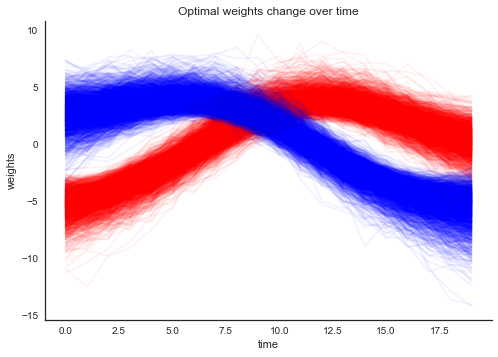

In [7]:
plt.plot(trace_perceptron['w'][:, :, 0].T, alpha=.05, color='r');
plt.plot(trace_perceptron['w'][:, :, 1].T, alpha=.05, color='b');
plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();

As you can see, the weights are slowly changing over time. What does the learned hyperplane look like? In the plot below, the points are still the training data but the background color codes the class probability learned by the model.

In [8]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

X_shared.set_value(grid_2d)
Y_shared.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace_perceptron, model=random_walk_perceptron, samples=500)

def create_surface(X, Y, grid, ppc, fig=None, ax=None):
    artists = []
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour = ax.contourf(*grid, ppc, cmap=cmap)
    artists.extend(contour.collections)
    artists.append(ax.scatter(X[Y==0, 0], X[Y==0, 1], color='b'))
    artists.append(ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r'))
    _ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X1', ylabel='X2');
    return artists

fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)
    
anim2 = animation.ArtistAnimation(fig, axs,
                                 interval=1000);
display_animation(anim2)

100%|██████████| 500/500 [00:23<00:00, 24.47it/s]


Nice, we can see that the random-walk logistic regression adapts its weights to perfectly separate the two point clouds.

## Random-Walk Neural Network

In the previous example, we had a very simple linearly classifiable problem. Can we extend this same idea to non-linear problems and build a Bayesian Neural Network with weights adapting over time?

If you haven't, I recommend you read my original post on [Bayesian Deep Learning](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) where I more thoroughly explain how a Neural Network can be implemented and fit in `PyMC3`.

Lets generate some toy data that is not linearly separable and again rotate it around its center.

In [9]:
from sklearn.datasets import make_moons
X, Y = make_moons(noise=0.2, random_state=0, n_samples=5000)
X = scale(X)

colors = Y.astype(str)
colors[Y == 0] = 'r'
colors[Y == 1] = 'b'

interval = 20
subsample = X.shape[0] // interval
chunk = np.arange(0, X.shape[0]+1, subsample)
degs = np.linspace(0, 360, len(chunk))

sep_lines = []

for ii, (i, j, deg) in enumerate(list(zip(np.roll(chunk, 1), chunk, degs))[1:]):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X[i:j, :] = X[i:j, :].dot(R)

In [28]:
fig, ax = plt.subplots()
ims = []
for i in np.arange(0, len(X), 10):
    ims.append((ax.scatter(X[:i, 0], X[:i, 1], color=colors[:i]),))

ax.set(xlabel='X1', ylabel='X2')
anim = animation.ArtistAnimation(fig, ims,
                                 interval=500, 
                                 blit=True);

display_animation(anim)

Looks a bit like Ying and Yang, who knew we'd be creating art in the process.

On to the model. Rather than have all the weights in the network follow random-walks, we will just have the first hidden layer change its weights. The idea is that the higher layers learn stable higher-order representations while the first layer is transforming the raw data so that it appears stationary to the higher layers. We can of course also place random-walk priors on all weights, or only on those of higher layers, whatever assumptions you want to build into the model.

In [11]:
np.random.seed(123)

ann_input = theano.shared(X)
ann_output = theano.shared(Y)

n_hidden = [2, 5]

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    step_size = pm.HalfNormal('step_size', sd=np.ones(n_hidden[0]), 
                              shape=n_hidden[0])
    
    weights_in_1 = pm.GaussianRandomWalk('w1', sd=step_size, 
                                         shape=(interval, X.shape[1], n_hidden[0]),
                                         testval=np.tile(init_1, (interval, 1, 1))
                                        )
    
    weights_in_1_rep = tt.repeat(weights_in_1, 
                                 ann_input.shape[0] // interval, axis=0)
    
    weights_1_2 = pm.Normal('w2', mu=0, sd=1., 
                            shape=(1, n_hidden[0], n_hidden[1]),
                            testval=init_2)
    
    weights_1_2_rep = tt.repeat(weights_1_2, 
                                ann_input.shape[0], axis=0)
    
    weights_2_out = pm.Normal('w3', mu=0, sd=1.,
                              shape=(1, n_hidden[1]),
                              testval=init_out)
    
    weights_2_out_rep = tt.repeat(weights_2_out, 
                                  ann_input.shape[0], axis=0)
      

    # Build neural-network using tanh activation function
    act_1 = tt.tanh(tt.batched_dot(ann_input, 
                         weights_in_1_rep))
    act_2 = tt.tanh(tt.batched_dot(act_1, 
                         weights_1_2_rep))
    act_out = tt.nnet.sigmoid(tt.batched_dot(act_2, 
                                             weights_2_out_rep))
        
    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

Hopefully that's not too incomprehensible. It is basically applying the principles from the random-walk logistic regression but adding another hidden layer.

I also want to take the opportunity to look at what the Bayesian approach to Deep Learning offers. Usually, we fit these models using point-estimates like the MLE or the MAP. Let's see how well that works on a structually more complex model like this one:

In [12]:
import scipy.optimize
with neural_network:
    map_est = pm.find_MAP(fmin=scipy.optimize.fmin_l_bfgs_b)

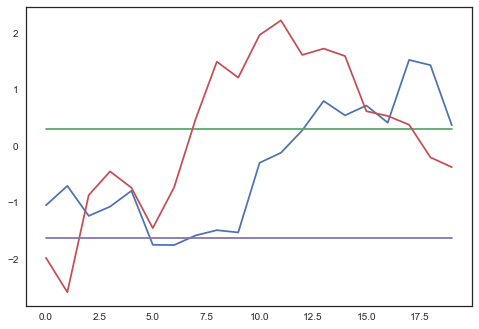

In [13]:
plt.plot(map_est['w1'].reshape(20, 4));

Some of the weights are changing, maybe it worked? How well does it fit the training data:

In [14]:
ppc = pm.sample_ppc([map_est], model=neural_network, samples=1)
print('Accuracy on train data = {:.2f}%'.format((ppc['out'] == Y).mean() * 100))

100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

Accuracy on train data = 76.64%


Now on to estimating the full posterior, as a proper Bayesian would:

In [15]:
with neural_network:
    trace = pm.sample(1000, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -538.86: 100%|██████████| 200000/200000 [13:06<00:00, 254.43it/s]
Finished [100%]: Average ELBO = -538.69
100%|██████████| 1000/1000 [1:22:05<00:00,  4.97s/it]


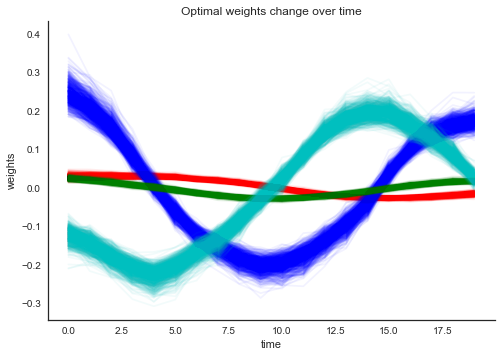

In [16]:
plt.plot(trace['w1'][200:, :, 0, 0].T, alpha=.05, color='r');
plt.plot(trace['w1'][200:, :, 0, 1].T, alpha=.05, color='b');
plt.plot(trace['w1'][200:, :, 1, 0].T, alpha=.05, color='g');
plt.plot(trace['w1'][200:, :, 1, 1].T, alpha=.05, color='c');

plt.xlabel('time'); plt.ylabel('weights'); plt.title('Optimal weights change over time'); sns.despine();

That already looks quite different. What about the accuracy:

In [17]:
ppc = pm.sample_ppc(trace, model=neural_network, samples=100)
print('Accuracy on train data = {:.2f}%'.format(((ppc['out'].mean(axis=0) > .5) == Y).mean() * 100))

100%|██████████| 100/100 [00:00<00:00, 112.04it/s]

Accuracy on train data = 96.72%


I think this is worth highlighting. The point-estimate did not do well at all, but estimating the whole posterior we were able to model the data much more accurately. I'm not quite sure why that is the case. It's possible that we either did not find the true MAP because the optimizer can't deal with the correlations in the posterior as well was NUTS can, or the MAP is just not a good point. See my [other blog post on hierarchical models](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) why the MAP is a terrible choice for some models.

On to the fireworks. What does this actually look like:

In [18]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
grid_2d = np.tile(grid_2d, (interval, 1))
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].mean(axis=0).reshape(100, 100), fig=fig, ax=ax)
    axs.append(a)
    
anim2 = animation.ArtistAnimation(fig, axs,
                                  interval=1000);
display_animation(anim2)

100%|██████████| 500/500 [00:58<00:00,  7.82it/s]


Holy shit! I can't believe that actually worked. Just for fun, let's also make use of the fact that we have the full posterior and plot our uncertainty of our prediction (the background now encodes posterior standard-deviation where red means high uncertainty).

In [19]:
fig, ax = plt.subplots()
chunk = np.arange(0, X.shape[0]+1, subsample)
chunk_grid = np.arange(0, grid_2d.shape[0]+1, 10000)
axs = []
for (i, j), (i_grid, j_grid) in zip((list(zip(np.roll(chunk, 1), chunk))[1:]), (list(zip(np.roll(chunk_grid, 1), chunk_grid))[1:])):
    a = create_surface(X[i:j], Y[i:j], grid, ppc['out'][:, i_grid:j_grid].std(axis=0).reshape(100, 100), 
                       fig=fig, ax=ax)
    axs.append(a)

anim2 = animation.ArtistAnimation(fig, axs,
                                  interval=1000);
display_animation(anim2)

## Conclusions

In this blog post I explored the possibility of extending Neural Networks in new ways (to my knowledge), enabled by expressing them in a Probabilistic Programming framework. Using a classic point-estimate did not provide a good fit for the data, only full posterior inference using [MCMC](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) allowed us to fit this model adequately. What is quite nice, is that we did not have to do anything special for the inference in `PyMC3`, just calling `pymc3.sample()` gave stable results on this complex model.

Initially I built the model allowing all parameters to change, but realizing that we can selectively choose which layers to change felt like a profound insight. If you expect the raw data to change, but the higher-level representations to remain stable, as was the case here, we allow the bottom hidden layers to change. If we instead imagine e.g. handwriting recognition, where your handwriting might change over time, we would expect lower level features (lines, curves) to remain stable but allow changes in how we combine them. Finally, if the world remains stable but the labels might change, we would place a random-walk process on the output layer. Of course, if you don't know you can have every layer change its weights over time and give each one a separate step-size parameter which would allow the model to figure out which layers change (high step-size), and which remain stable (low step-size).

In terms of quantatitative finance, this type of model allows us to train on much larger data sets ranging back a long time. A lot of that data is still useful to build up stable hidden representations, even if for predicition you still want your model to predict using its most up-to-date state of the world. No need to define a window-length or discard valuable training data.

In [24]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,sklearn,theano,pymc3,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.0
IPython 5.1.0

numpy 1.11.3
scipy 0.18.1
sklearn 0.18.1
theano 0.9.0beta1.dev-9f1aaacb6e884ebcff9e249f19848db8aa6cb1b2
pymc3 3.0
matplotlib 2.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
